<a href="https://colab.research.google.com/github/aslla77/practice-Python/blob/main/2nd/25_GTSRB_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GTSRB Project

- GTSRB 란?
  - 교통표지판 데이터로 독일 신경 정보학 연구원이 모은 데이터

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D

In [12]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip

--2022-08-21 11:25:17--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip.1’

GTSRB_Final_Trainin 100%[===================>] 263.50M  26.1MB/s    in 11s     

2022-08-21 11:25:29 (23.9 MB/s) - ‘GTSRB_Final_Training_Images.zip.1’ saved [276294756/276294756]



In [16]:
import zipfile

with zipfile.ZipFile('/content/GTSRB_Final_Training_Images.zip','r') as target_file:
  target_file.extractall()

In [17]:
import os
ROOT_DIR='/content'

DATA_ROOT_DIR=os.path.join(ROOT_DIR,'GTSRB/Final_Training/Images/')

In [18]:
import cv2
import glob
import numpy as np

image_list = []
label_list = []

image_label_list = os.listdir(DATA_ROOT_DIR)    # 정답이름

for label_name in image_label_list:

    # 이미지 파일 읽어오기

    file_path = os.path.join(DATA_ROOT_DIR, label_name)
    img_file_list = glob.glob(file_path+'/*.ppm')

    # 각각의 정답 디렉토리에 있는 이미지 파일, 즉 .ppm 파일 읽어서 리스트에 저장
    
    for img_file in img_file_list:

        try:
            src_img = cv2.imread(img_file, cv2.IMREAD_COLOR) 
            src_img = cv2.resize(src_img, dsize=(32,32))
            src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

            image_list.append(src_img)
            label_list.append(float(label_name))  # 정답은 문자열을 실수로 변환

        except Exception as err:
            print(str(err), img_file)
            continue

In [19]:
x_train = np.array(image_list).astype('float32')
y_train = np.array(label_list).astype('float32')

print('x_train.shape = ', x_train.shape, ', y_train.shape = ', y_train.shape)

x_train.shape =  (39209, 32, 32, 3) , y_train.shape =  (39209,)


In [21]:
s = np.arange(len(x_train))  # [ 0 1 2...39206 39207 39208]

np.random.shuffle(s)         # index random shuffle

x_train = x_train[s]
y_train = y_train[s]

SPLIT_RATIO = 0.2    # 20%

SPLIT_NUMS = int(SPLIT_RATIO*len(x_train))

x_test = x_train[0:SPLIT_NUMS]
y_test = y_train[0:SPLIT_NUMS]

x_train = x_train[SPLIT_NUMS:]
y_train = y_train[SPLIT_NUMS:]

In [22]:
print('x_train.shape = ', x_train.shape, ', y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape, ', y_test.shape = ', y_test.shape)

x_train.shape =  (31368, 32, 32, 3) , y_train.shape =  (31368,)
x_test.shape =  (7841, 32, 32, 3) , y_test.shape =  (7841,)


In [23]:
# 정규화 

x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

In [24]:
n_classes = len(os.listdir(DATA_ROOT_DIR))  # 정답 개수
input_=tf.keras.layers.Input(shape=(32,32,3))

x=Conv2D(32,(3,3),activation='relu')(input_)
x=Conv2D(64,(3,3),activation='relu')(x)
x=MaxPooling2D(pool_size=(2,2))(x)
x=Dropout(0.25)(x)

x=Flatten()(x)
x=Dense(256,activation='relu')(x)
x=Dropout(0.5)(x)
output_=Dense(n_classes,activation='softmax')(x)

model=Model(inputs=input_,outputs=output_)

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 flatten_5 (Flatten)         (None, 12544)             0         
                                                           

In [25]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [26]:
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime

earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)   

start_time = datetime.now()

hist = model.fit(x_train, y_train, batch_size=32, epochs=30, 
                 validation_data=(x_test, y_test), callbacks=[earlystopping])

end_time = datetime.now()

print('elapsed time => ', end_time-start_time)

Epoch 1/30
981/981 [==============================] - 158s 160ms/step - loss: 0.9938 - accuracy: 0.7255 - val_loss: 0.1573 - val_accuracy: 0.9657
Epoch 2/30
981/981 [==============================] - 149s 151ms/step - loss: 0.2407 - accuracy: 0.9282 - val_loss: 0.0763 - val_accuracy: 0.9838
Epoch 3/30
981/981 [==============================] - 151s 154ms/step - loss: 0.1413 - accuracy: 0.9572 - val_loss: 0.0486 - val_accuracy: 0.9892
Epoch 4/30
981/981 [==============================] - 151s 154ms/step - loss: 0.1045 - accuracy: 0.9690 - val_loss: 0.0355 - val_accuracy: 0.9909
Epoch 5/30
981/981 [==============================] - 149s 151ms/step - loss: 0.0789 - accuracy: 0.9764 - val_loss: 0.0315 - val_accuracy: 0.9925
Epoch 6/30
981/981 [==============================] - 149s 152ms/step - loss: 0.0647 - accuracy: 0.9796 - val_loss: 0.0270 - val_accuracy: 0.9934
Epoch 7/30
981/981 [==============================] - 150s 153ms/step - loss: 0.0566 - accuracy: 0.9822 - val_loss: 0.0281 -

In [27]:
model.evaluate(x_test, y_test)

246/246 [==============================] - 9s 36ms/step - loss: 0.0243 - accuracy: 0.9953


[0.024311568588018417, 0.9952812194824219]

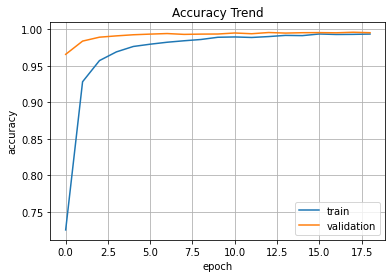

In [28]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

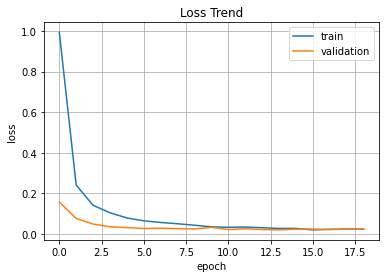

In [29]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss Trend')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()